In [1]:
import os
import sys
import pandas as pd
from sklearnex import patch_sklearn
import matplotlib.pyplot as plt

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))
from src.utils.utils import load_inbreast_mask, load_json

# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


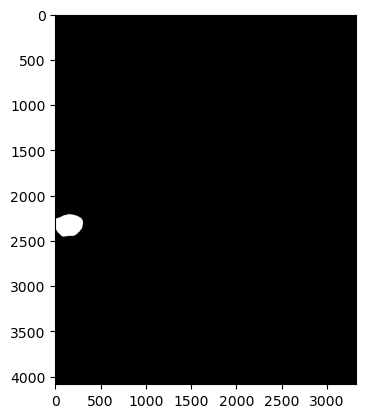

In [2]:
metadata = load_json("extracted_metadata_INBREAST", "../../outputs/mamografia/extracted_metadata")
cropped_path = metadata[3]['metadata_csv']['cropped_image_path']
img = load_inbreast_mask(cropped_path)

fig = plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

# Modelos preditivo

## Configuração

In [3]:
SELECTED_DATABASE = "CBIS-DDSM"

## Importação e análise dos conjuntos de dados

Iniciamos importando o conjunto de dados e realizamos a visualização das 5 primeiras linhas para verificar a estrutura dos dados.

In [4]:
breast_cancer_df = None

match SELECTED_DATABASE:
    case "CMMD":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_CMMD.csv")
    case "CBIS-DDSM":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_CBIS-DDSM.csv")
    case "INBREAST":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_INBREAST.csv")
    case "MIAS":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_MIAS.csv")
    case _:
        raise Exception("Database not found!")
    
breast_cancer_df.head()

,mean,std,variance,skewness,kurtosis,dissimilarity_ang_0_dist_1,dissimilarity_ang_45_dist_1,dissimilarity_ang_90_dist_1,dissimilarity_ang_135_dist_1,dissimilarity_ang_0_dist_3,...,energy_ang_0_dist_1,energy_ang_45_dist_1,energy_ang_90_dist_1,energy_ang_135_dist_1,energy_ang_0_dist_3,energy_ang_45_dist_3,energy_ang_90_dist_3,energy_ang_135_dist_3,pathology,image_path
0,127.260453,5315.523829,72.907639,0.000418,-1.254711,82.867668,82.997923,83.627085,83.525309,83.068380,...,0.015880,0.014749,0.015344,0.014554,0.013838,0.013827,0.013744,0.013835,benign,D:\mathe\Documents\BancoDados_IC\Mamografia\CB...
1,0.699270,177.824849,13.335098,19.017592,359.668805,0.007659,0.013195,0.008244,0.011729,0.022992,...,0.997246,0.997234,0.997245,0.997237,0.997214,0.997207,0.997211,0.997212,benign,D:\mathe\Documents\BancoDados_IC\Mamografia\CB...
2,128.491127,5446.287657,73.798968,-0.011641,-1.195563,85.414394,85.543713,84.963247,85.292415,85.499770,...,0.006222,0.006131,0.006151,0.006098,0.006061,0.006055,0.006040,0.006054,benign,D:\mathe\Documents\BancoDados_IC\Mamografia\CB...
3,0.653422,166.195599,12.891687,19.678817,385.255849,0.007924,0.012117,0.007359,0.012223,0.023787,...,0.997424,0.997416,0.997426,0.997415,0.997392,0.997391,0.997396,0.997391,benign,D:\mathe\Documents\BancoDados_IC\Mamografia\CB...
4,126.906768,5459.992327,73.891761,0.005717,-1.199054,85.319503,85.287985,85.294742,85.304762,85.612107,...,0.006696,0.006598,0.006672,0.006590,0.006543,0.006538,0.006532,0.006540,benign_without_callback,D:\mathe\Documents\BancoDados_IC\Mamografia\CB...


Como último passo, verificamos a distribuição das classes. 

In [5]:
breast_cancer_df["pathology"].value_counts(normalize=True)

malignant                  0.411405
benign                     0.395336
benign_without_callback    0.193259
Name: pathology, dtype: float64

## Pré-Processamento

In [6]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
if SELECTED_DATABASE == "CBIS-DDSM":
    breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
elif SELECTED_DATABASE == "INBREAST":
    breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology", "image_path"], axis=1), breast_cancer_df["pathology"])

""" drop_columns = []
for column in X.columns:
    if column in ["mean", "std", "variance", "skewness", "kurtosis"]:
    #if 'ang' in column:
        drop_columns.append(column)
X = X.drop(drop_columns, axis=1) """

# Balanceamento de classes
if SELECTED_DATABASE in ["CMMD"]:
    nm = NearMiss(version=1)
    X, y = nm.fit_resample(X, y)
elif SELECTED_DATABASE == "INBREAST" or SELECTED_DATABASE == "MIAS":
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

""" # Salva e retira image_path
image_paths_train = X_train["image_path"]
image_paths_test = X_test["image_path"]
X_train = X_train.drop("image_path", axis=1)
X_test = X_test.drop("image_path", axis=1) """

# Padroniza os dados
columns = X_train.columns
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

# Tratamos os rótulos categóricos
""" y_train = y_train.map({"normal": 0, "abnormal": 1})
y_test = y_test.map({"normal": 0, "abnormal": 1}) """
y_train = y_train.map({"benign": 0, "malignant": 1})
y_test = y_test.map({"benign": 0, "malignant": 1})

print("y_train: \n", y_train.value_counts(normalize=True))
print("y_test: \n", y_test.value_counts(normalize=True))

y_train: 
 1    0.509947
0    0.490053
Name: pathology, dtype: float64
y_test: 
 1    0.509988
0    0.490012
Name: pathology, dtype: float64


In [7]:
X_train.head()

,mean,std,variance,skewness,kurtosis,dissimilarity_ang_0_dist_1,dissimilarity_ang_45_dist_1,dissimilarity_ang_90_dist_1,dissimilarity_ang_135_dist_1,dissimilarity_ang_0_dist_3,...,ASM_ang_90_dist_3,ASM_ang_135_dist_3,energy_ang_0_dist_1,energy_ang_45_dist_1,energy_ang_90_dist_1,energy_ang_135_dist_1,energy_ang_0_dist_3,energy_ang_45_dist_3,energy_ang_90_dist_3,energy_ang_135_dist_3
0,1.037798,0.936252,0.939071,-0.778904,-0.356874,1.046645,1.041029,1.045622,1.042959,1.040909,...,-1.028734,-1.028689,-1.036595,-1.036033,-1.036146,-1.035905,-1.036397,-1.036529,-1.036904,-1.036359
1,1.033849,0.934494,0.937996,-0.779114,-0.356871,1.050339,1.048724,1.047040,1.047470,1.047454,...,-1.028870,-1.028833,-1.049967,-1.048215,-1.049040,-1.048164,-1.047097,-1.046982,-1.047094,-1.046979
2,1.050097,0.932083,0.936520,-0.779026,-0.356872,1.044070,1.046276,1.044853,1.041701,1.045506,...,-1.028749,-1.028711,-1.040058,-1.038563,-1.039200,-1.038556,-1.037745,-1.037604,-1.037736,-1.037591
3,1.037756,0.930020,0.935256,-0.779238,-0.356867,1.045998,1.040595,1.041337,1.041985,1.040552,...,-1.028855,-1.028817,-1.046777,-1.045904,-1.046155,-1.045900,-1.045428,-1.045332,-1.045450,-1.045251
4,1.035735,0.928995,0.934629,-0.779170,-0.356871,1.043709,1.038847,1.045681,1.042983,1.044750,...,-1.028762,-1.028725,-1.040172,-1.038902,-1.039362,-1.038951,-1.038531,-1.038299,-1.038458,-1.038365


## Treinamento dos modelos

### Variáveis

In [8]:
angles = ["0", "45", "90", "135"]
distances = ['1', '3']
threshold = 0.5 # Definir o limiar

### KNeighborsClassifier

In [9]:
# Treina com todos os angulos e distancias
knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean", algorithm="auto")

knn_model.fit(X_train, y_train)
predict = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100
#accuracy = (cross_val_score(knn_model, X_test, y_test, cv=kf).mean()) * 100

# predicts = {"KNeighborsClassifier": {"all": predict}}
scores = {"KNeighborsClassifier": {"all": {"accuracy_score": accuracy}}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean", algorithm="auto")
        # knn_model.fit(X_train_filtered, y_train)
        # predict = knn_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(knn_model, X_test_filtered, y_test, cv=kf).mean()) * 100

        #predicts["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = predict
        scores["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean", algorithm="auto")\n        # knn_model.fit(X_train_filtered, y_train)\n        # predict = knn_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(knn_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n\n        #predicts["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### Random Forest Classifier

In [10]:
# Treina com todos os angulos e distancias
random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, criterion="gini", 
                                             min_samples_leaf=3, min_samples_split=2)
random_forest_model.fit(X_train, y_train)
predict = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100
#accuracy = (cross_val_score(random_forest_model, X_test, y_test, cv=kf).mean()) * 100

# predicts["RandomForestClassifier"] = {"all": predict}
scores["RandomForestClassifier"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]
        
        random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, criterion="gini", 
                                                     min_samples_leaf=3, min_samples_split=2)
        
        # random_forest_model.fit(X_train_filtered, y_train)
        # predict = random_forest_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(random_forest_model, X_test_filtered, y_test, cv=kf).mean()) * 100

        # predicts["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = predict
        scores["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n        \n        random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, criterion="gini", \n                                                     min_samples_leaf=3, min_samples_split=2)\n        \n        # random_forest_model.fit(X_train_filtered, y_train)\n        # predict = random_forest_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(random_forest_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n\n        # predicts["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### Support Vector Machines

In [11]:
# Treina com todos os angulos e distancias
svm_model = svm.SVC(C=10, gamma='scale', kernel='linear')
svm_model.fit(X_train, y_train)
predict = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100
#accuracy = (cross_val_score(svm_model, X_test, y_test, cv=kf).mean()) * 100

# predicts["SVM"] = {"all": predict}
scores["SVM"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        svm_model = svm.SVC(C=10, gamma='scale', kernel='linear')
        
        # svm_model.fit(X_train_filtered, y_train)
        # predict = svm_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(svm_model, X_test_filtered, y_test, cv=kf).mean()) * 100

        # predicts["SVM"][f"ang_{angle}_dist_{distance}"] = predict
        scores["SVM"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        svm_model = svm.SVC(C=10, gamma=\'scale\', kernel=\'linear\')\n        \n        # svm_model.fit(X_train_filtered, y_train)\n        # predict = svm_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(svm_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n\n        # predicts["SVM"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["SVM"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### Boosted Tree Classifier

In [12]:
# Treina com todos os angulos e distancias
boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
boosted_tree_model.fit(X_train, y_train)
predict = boosted_tree_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100

scores["GradientBoostingClassifier"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
        
        # boosted_tree_model.fit(X_train_filtered, y_train)
        # predict = boosted_tree_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(boosted_tree_model, X_test_filtered, y_test, cv=kf).mean()) * 100
        
        # predicts["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = predict
        scores["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)\n        \n        # boosted_tree_model.fit(X_train_filtered, y_train)\n        # predict = boosted_tree_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(boosted_tree_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n        \n        # predicts["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### XGBoost

In [13]:
# Treina com todos os angulos e distancias
args_xgboost = {'objective': 'binary:logistic', 'colsample_bytree': 0.7, 'eta': 0.05, 'max_depth': 3, 'min_child_weight': 7,
                'subsample': 0.8, 'eval_metric': 'logloss'}
xgboost_model = XGBClassifier(**args_xgboost)
xgboost_model.fit(X_train, y_train)
predict = xgboost_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100

scores["XGBoost"] = {"all": {"accuracy_score": accuracy}}

### Multilayer Perceptron

In [14]:
# Função para criar o modelo do Keras
def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(50, input_dim=shape, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

# Treina com todos os angulos e distancias
mlp = create_mlp_model(X_test.shape[1])
mlp.fit(X_train, y_train, epochs=100, batch_size=5, verbose=0)

predict = mlp.predict(X_test)
predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
accuracy = accuracy_score(y_test, predict) * 100

scores["MultilayerPerceptron"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column ]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        #mlp = create_model(X_test_filtered.shape[1])
        #mlp.fit(X_train_filtered, y_train, epochs=100, batch_size=5, verbose=0)
        #predict = mlp.predict(X_test_filtered)
        
        #predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
        #accuracy = accuracy_score(y_test, predict) * 100
        accuracy = evaluate_mlp_model(create_mlp_model(X_test_filtered.shape[1]),
                              X_test_filtered, y_test, 5, 100, 5)

        #predicts["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = predict
        scores["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = { "accuracy_score": accuracy } """

54/54 [==============================] - 0s 1ms/step


' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column ]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        #mlp = create_model(X_test_filtered.shape[1])\n        #mlp.fit(X_train_filtered, y_train, epochs=100, batch_size=5, verbose=0)\n        #predict = mlp.predict(X_test_filtered)\n        \n        #predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos\n        #accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = evaluate_mlp_model(create_mlp_model(X_test_filtered.shape[1]),\n                              X_test_filtered, y_test, 5, 100, 5)\n\n        #predicts["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = { "accuracy_score": accuracy } '

## Avaliação dos modelos

### Acurácia

In [15]:
scores_knn = pd.DataFrame(scores["KNeighborsClassifier"])
scores_random_forest = pd.DataFrame(scores["RandomForestClassifier"])
scores_svm = pd.DataFrame(scores["SVM"])
scores_boosted_tree = pd.DataFrame(scores["GradientBoostingClassifier"])
scores_xgboost_tree = pd.DataFrame(scores["XGBoost"])
scores_perceptron = pd.DataFrame(scores["MultilayerPerceptron"])

merged_df = pd.concat([scores_knn, scores_random_forest, scores_svm, scores_boosted_tree,
                       scores_xgboost_tree, scores_perceptron], axis=0).reset_index(drop=True)
merged_df['model'] = ['KNN', 'Random Forest', 'SVM', 'Boosted Tree', 'XGBoost', 'Multilayer Perceptron']

columns = merged_df.columns.tolist()
columns.remove('model')

merged_df = merged_df[['model', *columns]]
merged_df

,model,all
0,KNN,55.405405
1,Random Forest,58.049354
2,SVM,56.462985
3,Boosted Tree,58.695652
4,XGBoost,58.695652
5,Multilayer Perceptron,57.638073


In [17]:
result = [
[54.817861, 59.753231, 54.054054, 57.696827, 59.341951, 53.642773],
[53.290247, 57.168038, 55.581669, 57.696827, 57.696827, 55.522914],
[53.290247, 57.168038, 55.581669, 57.696827, 57.696827, 55.522914],
[54.171563, 57.755582, 55.816686, 56.698002, 58.871915, 54.759107],
[55.405405, 58.049354, 56.462985, 58.695652, 58.695652, 57.638073]
]

columns=['KNN', 'Random Forest', 'SVM', 'Boosted Tree', 'XGBoost', 'Multilayer Perceptron']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    for col in df.columns:
        df[col] = df[col].sort_values()
        df[col] = df[col].drop(df[col].index[[0, -1]])
        df[col] = df[col].mean()
    return df

df = mean_without_extremes(df)
df

,KNN,Random Forest,SVM,Boosted Tree,XGBoost,Multilayer Perceptron
0,53.584019,57.363886,55.660008,57.363885,58.088523,55.268312
1,53.584019,57.363886,55.660008,57.363885,58.088523,55.268312
2,53.584019,57.363886,55.660008,57.363885,58.088523,55.268312
3,53.584019,57.363886,55.660008,57.363885,58.088523,55.268312
4,53.584019,57.363886,55.660008,57.363885,58.088523,55.268312
